In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import math
from functools import partial
from tqdm import tqdm
from p_tqdm import p_map, p_umap, p_imap, p_uimap
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Process
import time

plt.style.use('ggplot')

In [2]:
# This function implements the Knn classifier by computing the euclidean distance between data points
def knn(k, predicted_x, predicted_y, pool):
    
    predicted_dp = np.array([predicted_x, predicted_y, 0.0])
    distances = predicted_dp - pool
    distances = np.power(distances, 2)
    distances = distances[:,0:2] 
    distances = np.sum(distances, axis=1)
    distances = np.sqrt(distances)
    
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]

# Reading and understanding dataset

In [3]:
df = pd.read_csv('hw5data.txt', sep= ' ', names= ['x','y', 'class'])
df

x         y  class
0    0.776233  0.052780      1
1    0.992234  0.087356      1
2    0.263741  0.131315      1
3    0.079478  0.109225      1
4    0.688997  0.983182      1
..        ...       ...    ...
802  0.932700  0.875138      0
803  0.541090  0.555108      0
804  0.988755  0.194709      0
805  0.263414  0.974600      0
806  0.733660  0.835736      0

[807 rows x 3 columns]

<Axes: ylabel='Frequency'>

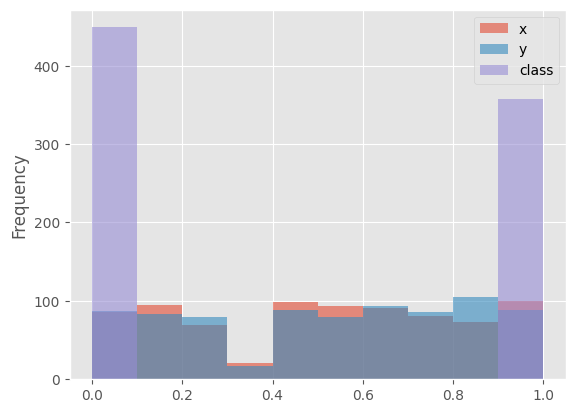

In [4]:
df.plot(kind= 'hist', alpha=0.6)

<Axes: xlabel='x', ylabel='y'>

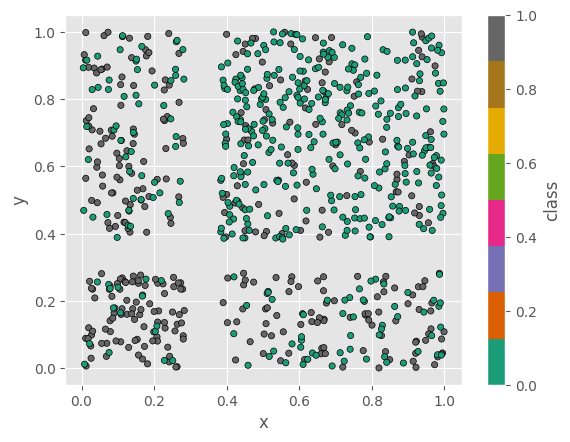

In [5]:
df.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'Dark2', edgecolor='k')

In [6]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:1:5j,0:1:5j]

n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

# Teaching/ student classifier, f: It has a array D which picks elements from P (hw5data.txt) D is a 
# subset or proper set of P, which holds the data points we want to include in teaching.
D = np.array([])
print(f'Dataset of teaching classifier: {D.shape}')

Dataset of target classifier: (807, 3)
Dataset of teaching classifier: (0,)


## Target classifier's expected result with test data (2D mesh)

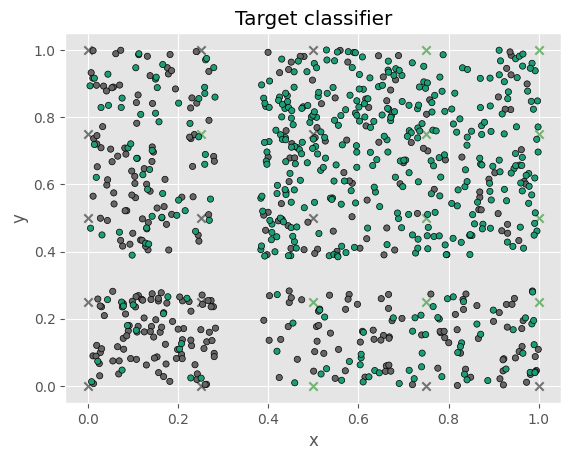

In [7]:
colors = {0: 'green', 1:'black'}
# View decision boundary of target classifier using all data points from the orignal pool
for X, Y in zip(mesh_X, mesh_Y):
    for x, y in zip(X, Y):
        result = knn(K, x,y, P)
        plt.scatter(x,y, c= colors[result],alpha= 0.5, marker='x')
        
temp_P = P.T
plt.scatter(temp_P[0], temp_P[1], c=temp_P[2], edgecolor='k', cmap='Dark2', s=20)
plt.title('Target classifier')
plt.xlabel('x')
plt.ylabel('y')
        
plt.show()

## Target classifier 2D mesh in matrix form 

In [8]:
%%time
# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
for i in range(len(mesh_X)):
    res = []
    for j in range(len(mesh_X[0])):
        res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

print(f'target mesh:\n {target_class_mesh} ') # The top left corner of the mesh is at origin, hence explaining the 90 degree anti-clockwise turn in the plot.

target mesh:
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] 
CPU times: user 6.76 ms, sys: 1.01 ms, total: 7.76 ms
Wall time: 2.65 ms


In [9]:
%%time
# Enumeration
# This function finds all combinations of size n given a pool of data points
def find_combination(n, pool):
    datasets = combinations(pool, n)
    return np.array(list(datasets))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [10]:
# Check if utilities class is imported successfully
import sys
import utilities 

modulename = 'utilities'
if modulename not in sys.modules:
    print('import not successful!')

In [11]:
import multiprocessing
# Check number of cpu cores
print(f'Max number of cores in this machine: {multiprocessing.cpu_count()}')

Max number of cores in this machine: 8


# Enumeration

In [12]:
max_N = 20
util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)

def enumeration(n_choosen):
    start = time.time()
    possible_pool_Ds = find_combination(n_choosen, P)
    best_teaching_set = None
    best_teaching_cost = math.inf 
    searched_teaching_set_size = len(possible_pool_Ds)
    total_time = 0

    with Pool(processes = multiprocessing.cpu_count() - 7) as p:
        size = len(possible_pool_Ds)

        with tqdm(total= size) as pbar:
            for result in p.imap_unordered(util_obj.disagreement_func_ex, possible_pool_Ds):
                pbar.update()
                if best_teaching_cost > result[0]:
                    best_teaching_cost = result[0]
                    best_teaching_set = result[1]
                    
        p.close()
        p.join()
    end = time.time()
    total_time = end - start
    
    return best_teaching_set, best_teaching_cost, searched_teaching_set_size, total_time

In [13]:
def analyze_enumeration(n_start, n_stop):
     
    list_best_teaching_set = [] 
    list_best_teaching_cost = [] 
    list_number_of_teaching_sets = [] 
    list_total_time = [] 
    for n in range(n_start, n_stop+1):
        best_teaching_set, best_teaching_cost, number_of_teaching_sets, total_time = enumeration(n_start)
        list_best_teaching_set.append(best_teaching_set)
        list_best_teaching_cost.append(best_teaching_cost)
        list_number_of_teaching_sets.append(number_of_teaching_sets)
        list_total_time.append(total_time)
        
    return list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time

In [14]:
def print_analyze_enumeration(n_start, n_stop):
    teaching_colors = {0: 'yellow', 1:'red'}
    list_best_teaching_sets, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time = analyze_enumeration(n_start, n_stop)
    
    ts_size = 2
    for best_teaching_set in list_best_teaching_sets:
        fig, ax = plt.subplots()
        ax.set_title(f'Enumeration: Teaching set data points $n$ = {ts_size}')
        ax.scatter(temp_P[0], temp_P[1], c=temp_P[2], cmap='Dark2', s=20, alpha= 0.7)
        ts = best_teaching_set.T
        # plt.scatter(ts[0], ts[1], c= [teaching_colors[color] for color in ts[2]], edgecolor='k')
        size_order = 20 
        for dp in best_teaching_set:
            ax.scatter(dp[0], dp[1], c= teaching_colors[dp[2]], edgecolor='k', label= dp[2], s= size_order)
            size_order+= 5
           
        ax.legend(bbox_to_anchor = (1, 1), title= "Increasing size with each addition of teaching items")
        plt.show()
        ts_size += 1
    
    plt.title('Enumeration (N distinct runs): New teaching set size (random restarts) vs disagreement function cost')
    plt.xlabel('New teaching set size')
    plt.ylabel('Disagreement function cost')
    plt.plot(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.scatter(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.show()
    
    plt.title('Enumeration (N distinct runs): New teaching set size (random restarts) vs searched teaching set size')
    plt.xlabel('New teaching set size')
    plt.ylabel('Searched teaching set size')
    plt.plot(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.scatter(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.show()
    
    plt.title('Enumeration (N distinct runs): New teaching set size (random restarts) vs time elapsed (s)')
    plt.xlabel('New teaching set size')
    plt.ylabel('Time elapsed (s)')
    plt.plot(range(2, len(list_total_time)+2), list_total_time)
    plt.scatter(range(2, len(list_total_time)+2), list_total_time)
    plt.show()


## Enumeration (results)

100%|█████████████████████████████████████████████████████| 325221/325221 [01:03<00:00, 5162.16it/s]


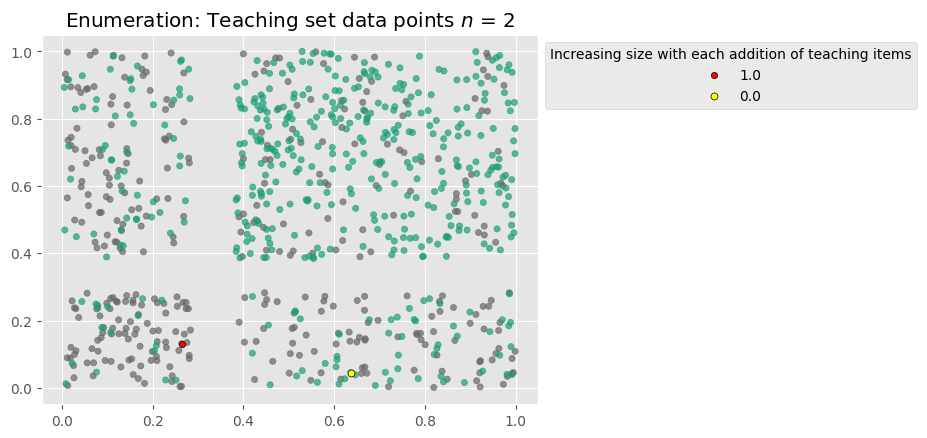

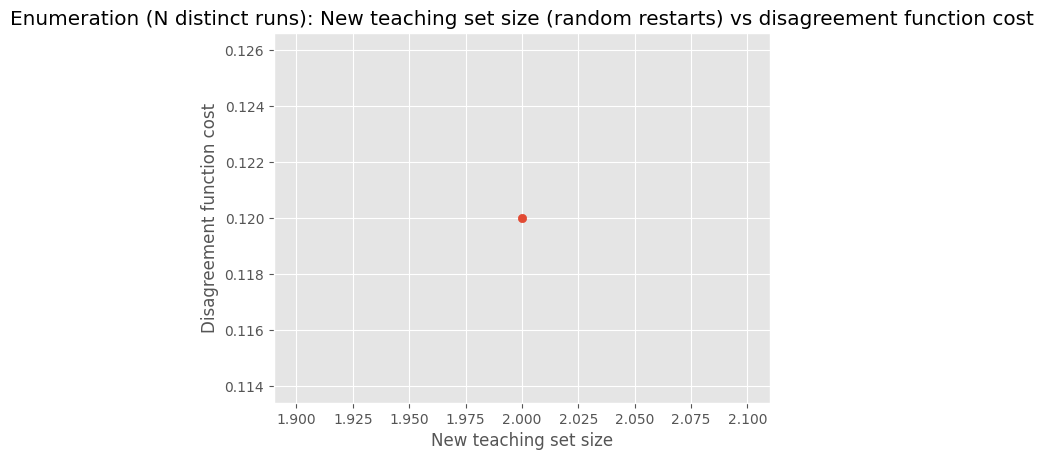

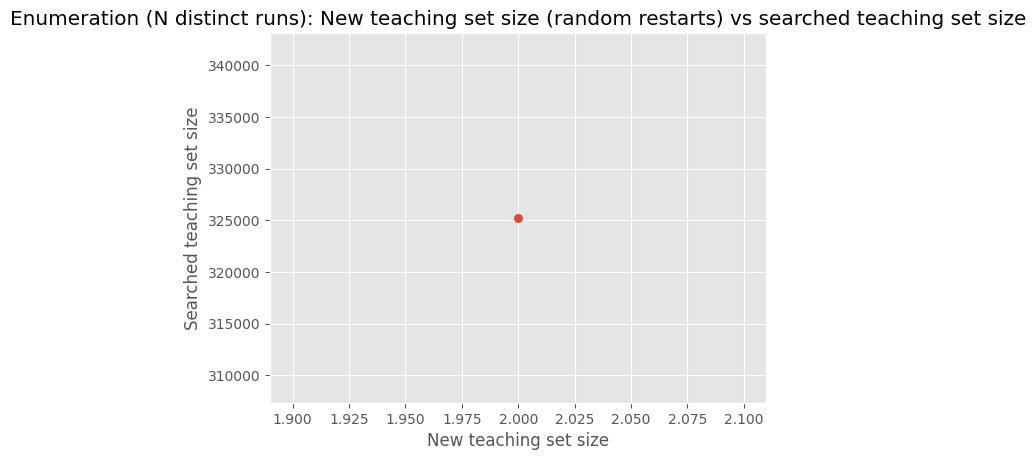

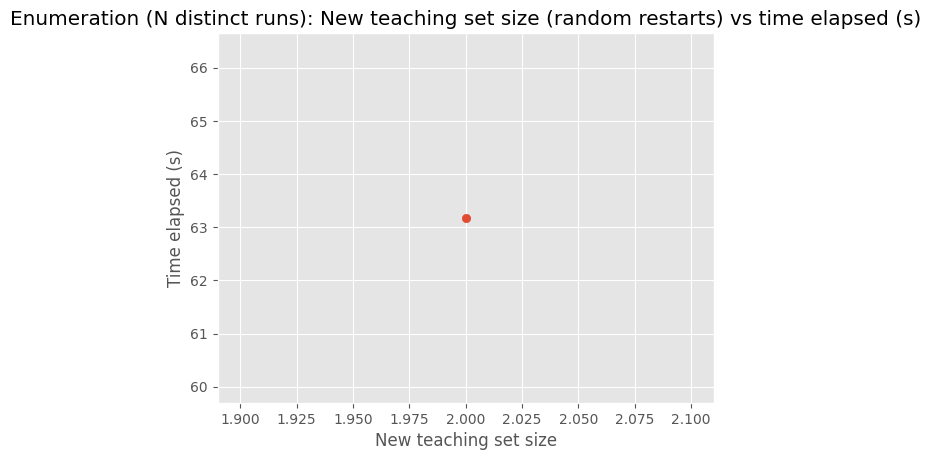

In [15]:
print_analyze_enumeration(2,2)

# Greedy 

In [16]:
import random
random.seed(10)


# Greedy
def greedy(n_stop):
    max_N = n_stop # Size of desired teaching set
    util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)
    
    start = time.time()
    cost = 0
    best_teaching_cost = math.inf 
    curr_best_teaching_cost = math.inf 
    curr_best_teaching_set = np.array([])
    best_teaching_set = np.array([])
    searched_teaching_set_size = 0
    
    copy_P = np.copy(P)
    # Randomly pick a data point to make the teaching set's size = 1.
    idx = random.randint(0, len(copy_P)-1) 
    # Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
   
    curr_D = np.array([copy_P[idx]])
    while not np.isinf(cost):
        curr_temp_best_teaching_cost = math.inf
        removed_idx = 0
        for i in range(len(copy_P)):
            searched_teaching_set_size += 1
            temp_D = np.append(curr_D, np.array([copy_P[i]]), axis=0)
            data = util_obj.disagreement_func_ex(temp_D)
            cost = data[0]
            if np.isinf(cost):
                break
            
            if cost < curr_temp_best_teaching_cost:
                curr_best_teaching_cost = cost
                curr_temp_best_teaching_cost = cost
                curr_best_teaching_set = temp_D 
                removed_idx = i
                
            if cost < best_teaching_cost:
                best_teaching_cost = cost
                best_teaching_set = temp_D 
       
        if not np.isinf(cost):
            curr_D = curr_best_teaching_set
            copy_P = np.delete(copy_P, removed_idx, axis=0)
        # print(curr_best_teaching_cost, len(curr_best_teaching_set))
   
    end = time.time()
    total_time = end - start 
    
    return curr_best_teaching_set, curr_best_teaching_cost, searched_teaching_set_size, total_time

In [17]:
def analyze_greedy(n_stop):
    list_best_teaching_set = [] 
    list_best_teaching_cost = [] 
    list_number_of_teaching_sets = [] 
    list_total_time = [] 
    for n in tqdm(range(2, n_stop+1)):
        best_teaching_set, best_teaching_cost, number_of_teaching_sets, total_time = greedy(n) 
        list_best_teaching_set.append(best_teaching_set)
        list_best_teaching_cost.append(best_teaching_cost)
        list_number_of_teaching_sets.append(number_of_teaching_sets)
        list_total_time.append(total_time)
        
    return list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time
    

In [18]:
def print_analyze_greedy(n_stop):
    
    teaching_colors = {0: 'yellow', 1:'red'}
    list_best_teaching_sets, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time = analyze_greedy(n_stop)
  
    ts_size = 2
    for best_teaching_set in list_best_teaching_sets:
        fig, ax = plt.subplots()
        ax.set_title(f'Greedy: Teaching set data points $n$ = {ts_size}')
        ax.scatter(temp_P[0], temp_P[1], c=temp_P[2], cmap='Dark2', s=20, alpha= 0.7)
        ts = best_teaching_set.T
        # plt.scatter(ts[0], ts[1], c= [teaching_colors[color] for color in ts[2]], edgecolor='k')
        size_order = 20 
        for dp in best_teaching_set:
            ax.scatter(dp[0], dp[1], c= teaching_colors[dp[2]], edgecolor='k', label= dp[2], s= size_order)
            size_order+= 5
           
        ax.legend(bbox_to_anchor = (1, 1), title= "Increasing size with each addition of teaching items")
        plt.show()
        ts_size += 1
    
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs disagreement function cost')
    plt.xlabel('New teaching set size')
    plt.ylabel('Disagreement function cost')
    plt.plot(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.scatter(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs searched teaching set size')
    plt.xlabel('New teaching set size')
    plt.ylabel('Searched teaching set size')
    plt.plot(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.scatter(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs time elapsed (s)')
    plt.xlabel('New teaching set size')
    plt.ylabel('Time elapsed (s)')
    plt.plot(range(2, len(list_total_time)+2), list_total_time)
    plt.scatter(range(2, len(list_total_time)+2), list_total_time)
    plt.show()

## Greedy (results)

100%|███████████████████████████████████████████████████████████████| 19/19 [00:27<00:00,  1.45s/it]


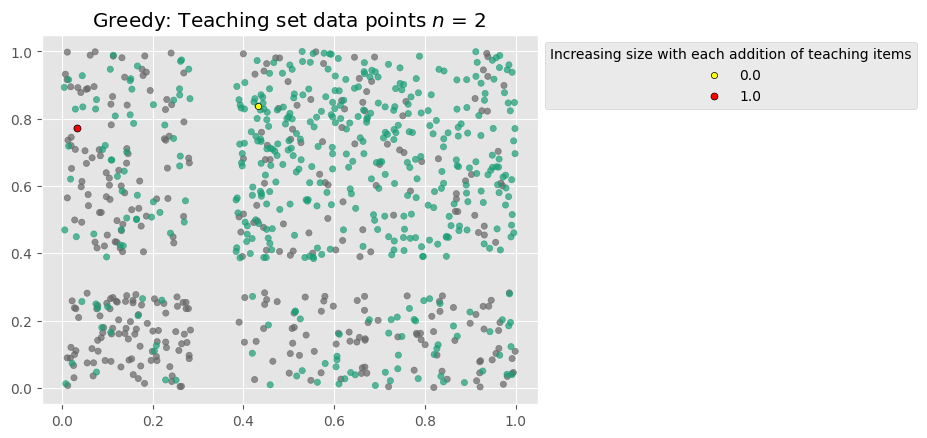

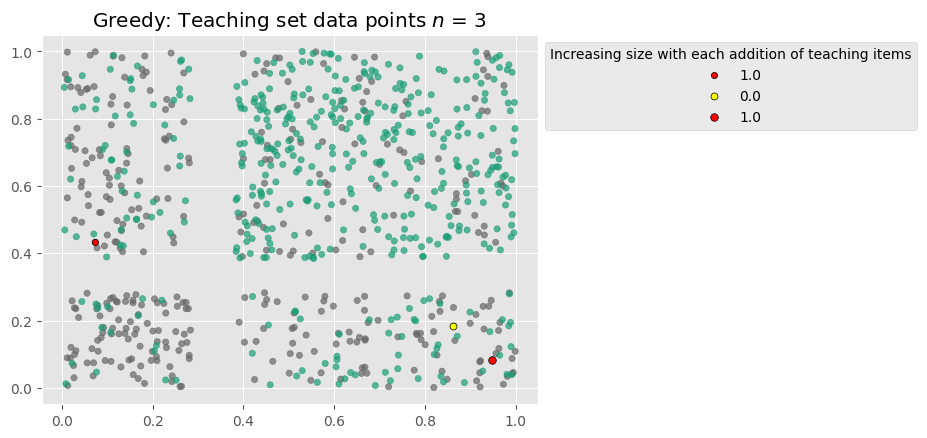

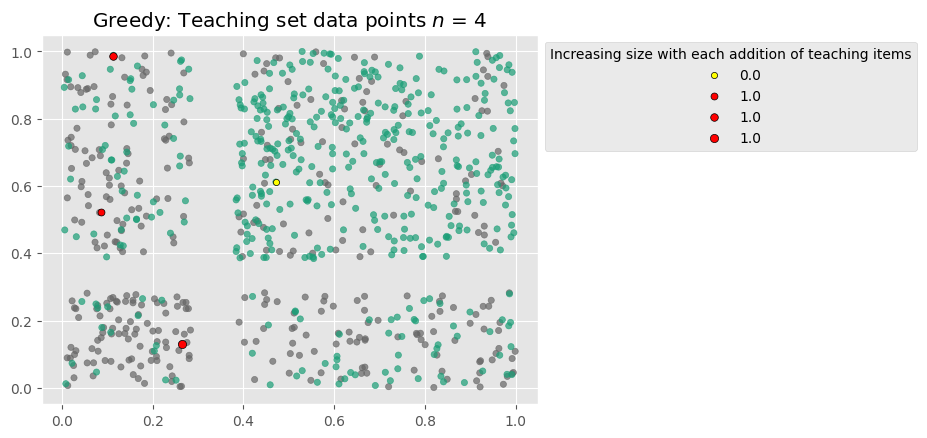

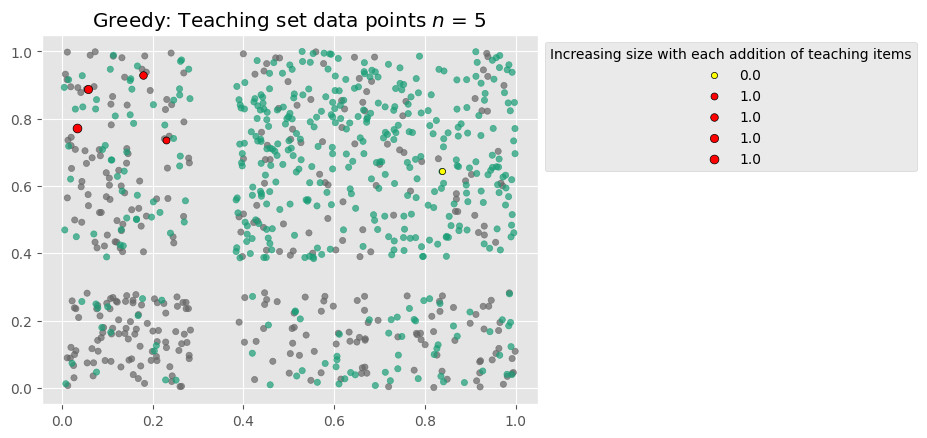

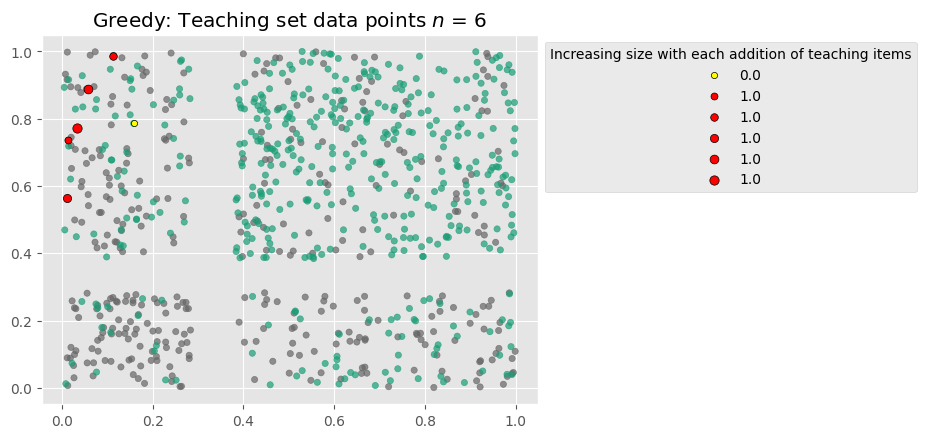

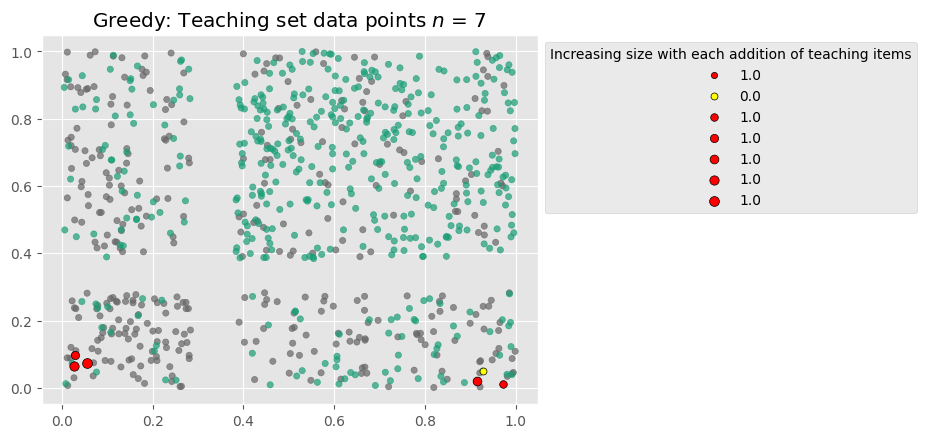

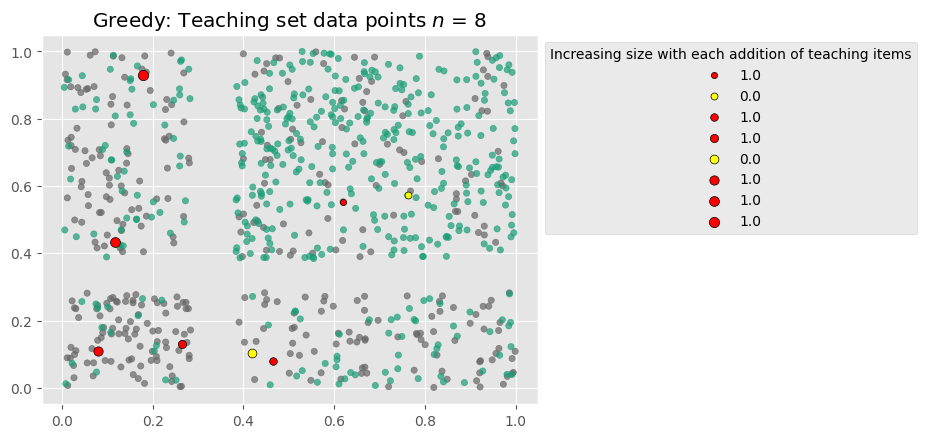

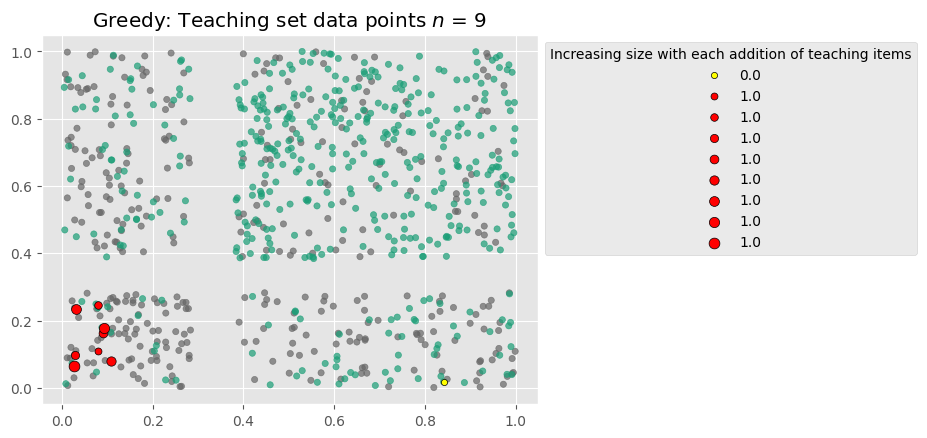

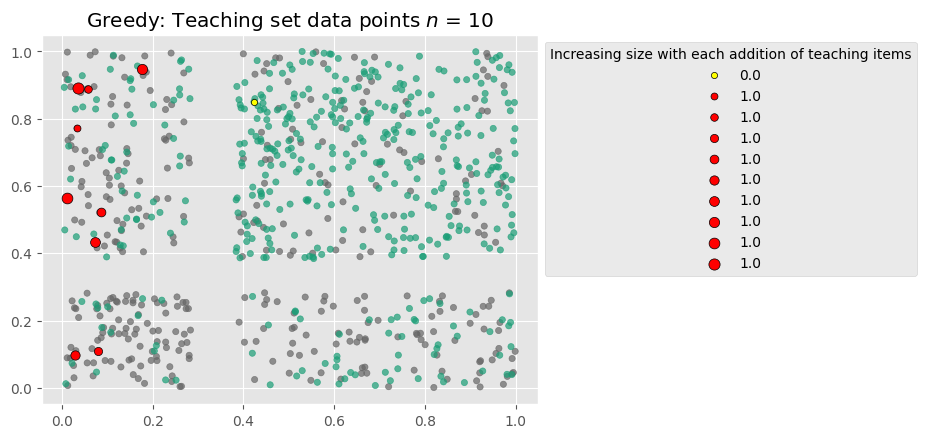

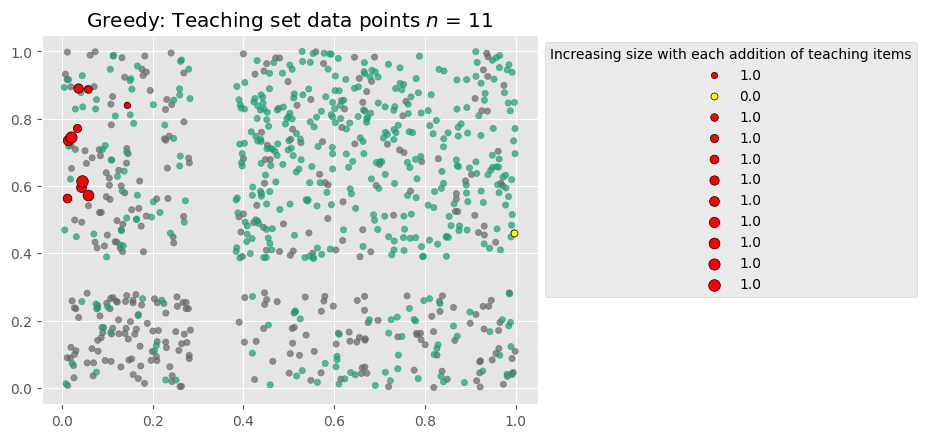

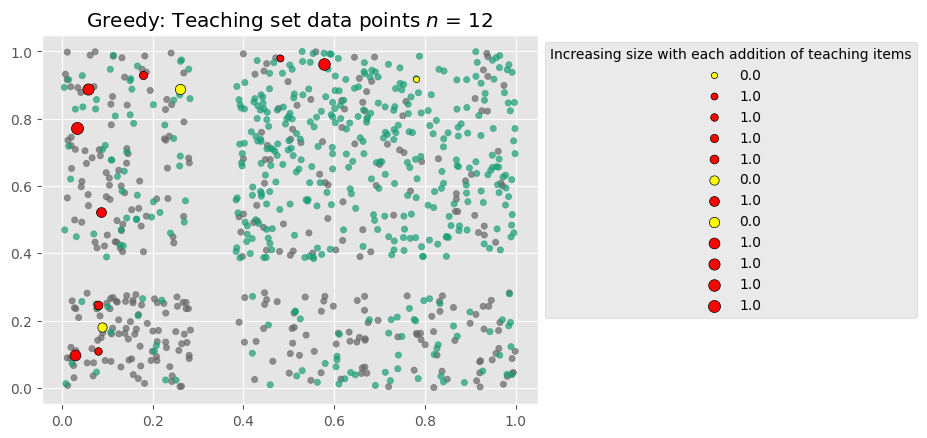

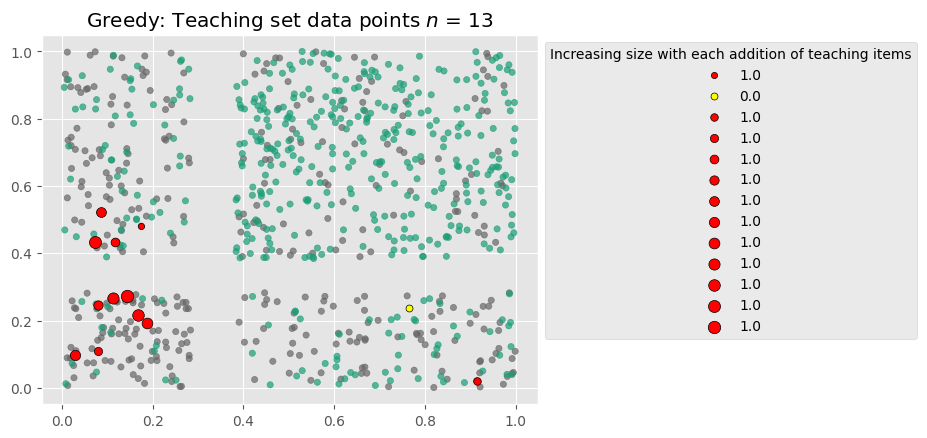

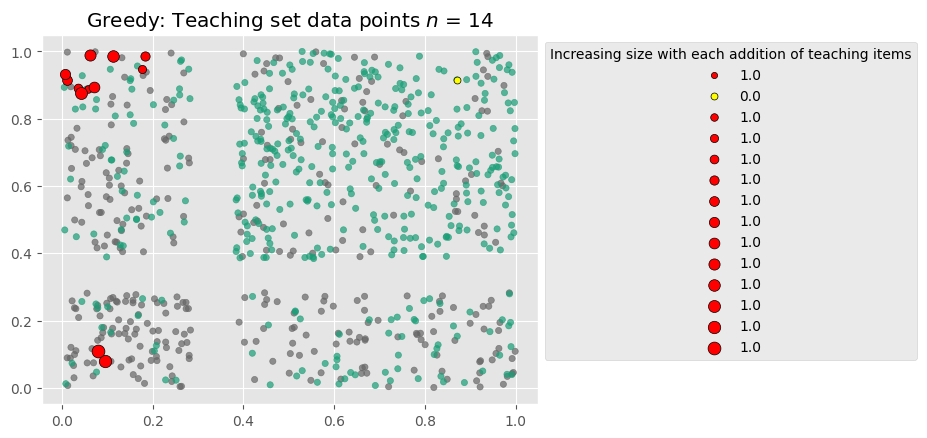

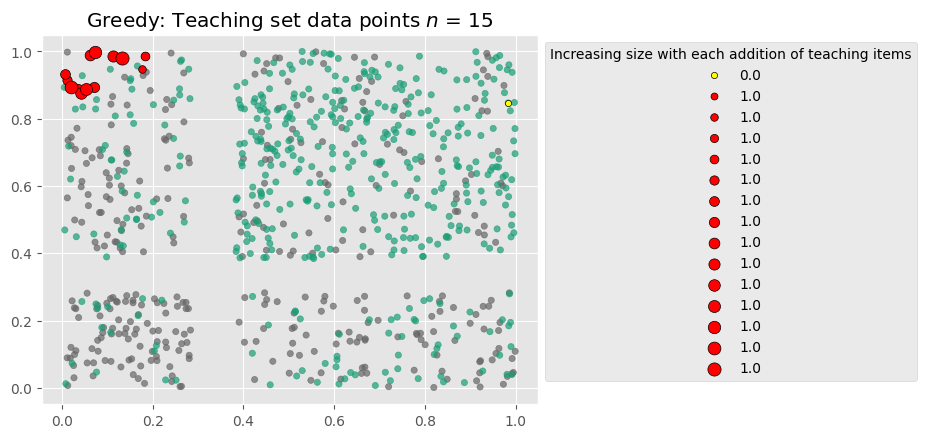

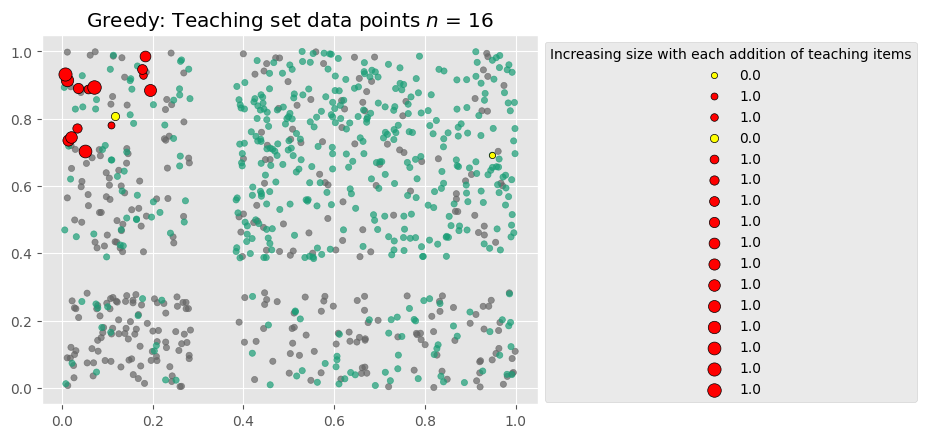

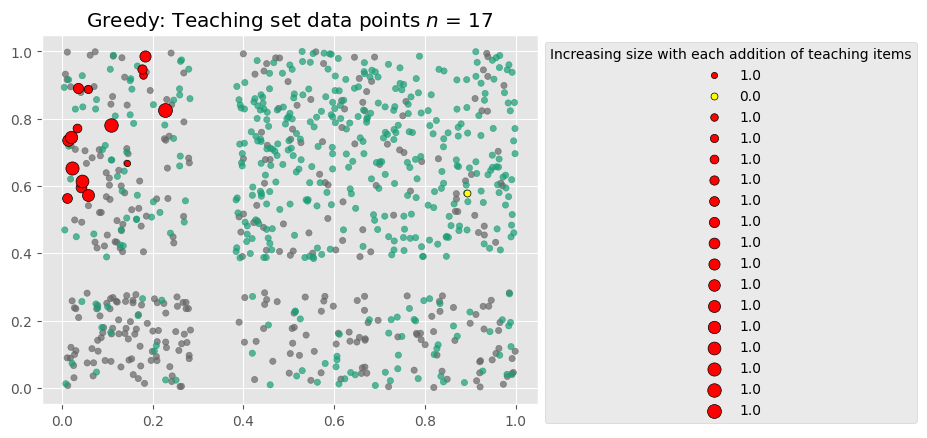

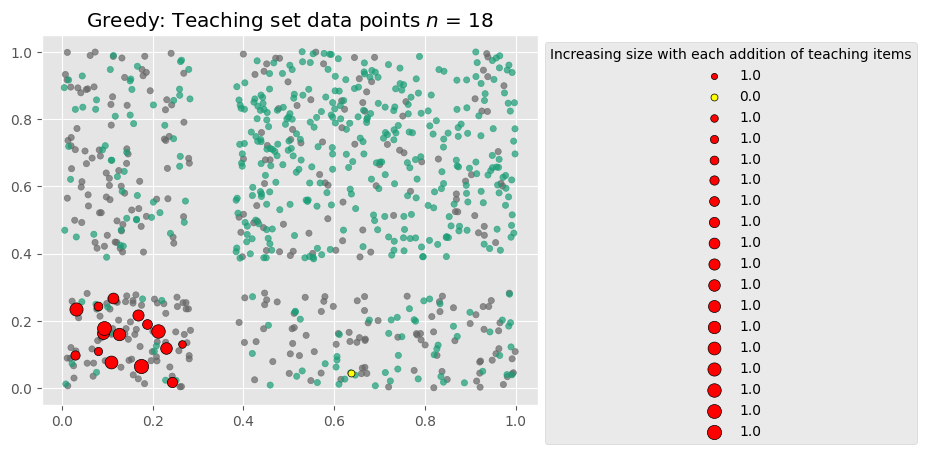

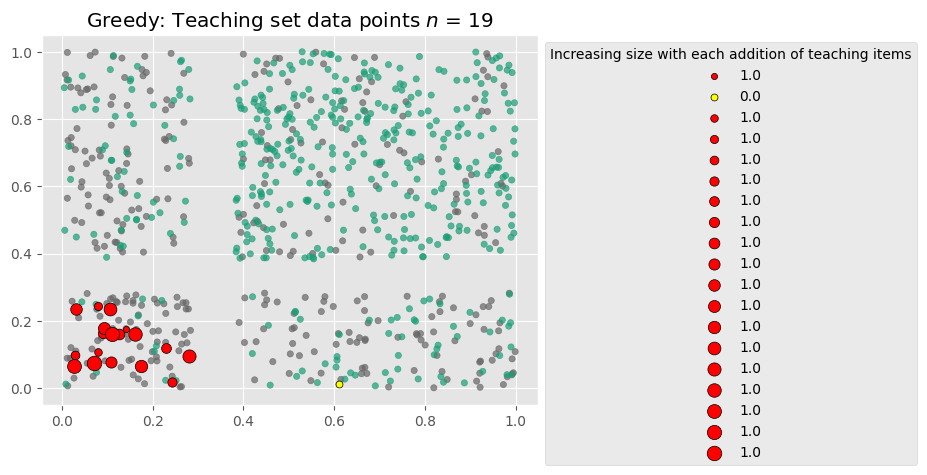

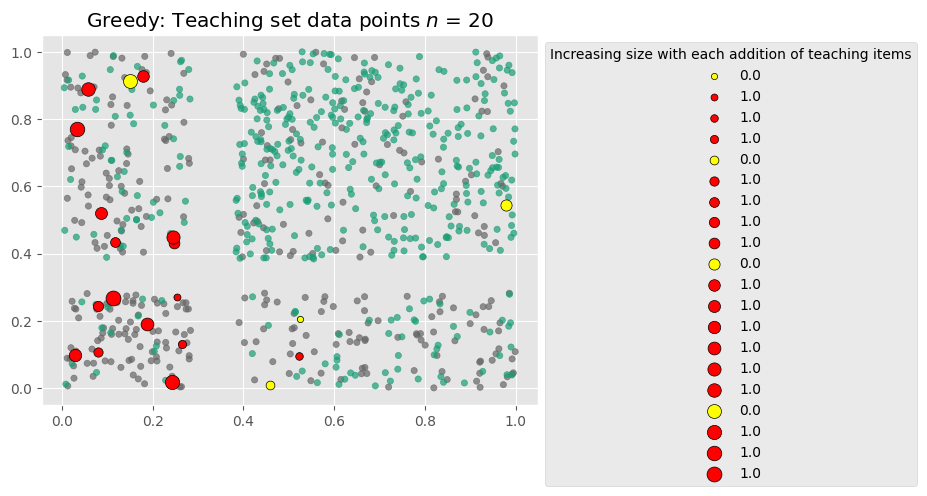

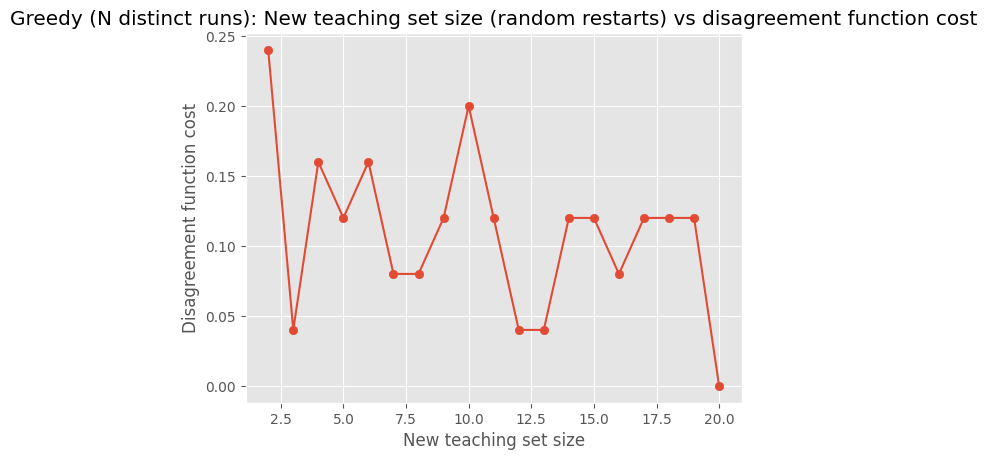

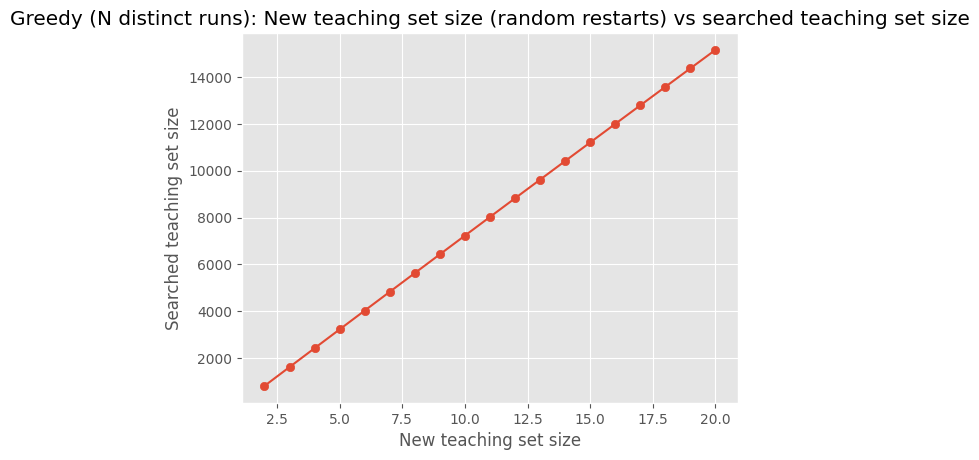

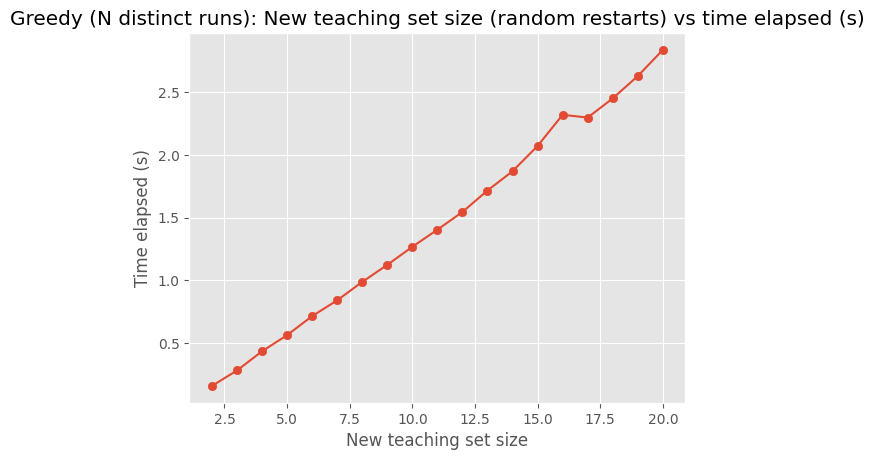

In [19]:
print_analyze_greedy(20)

In [22]:
# Greedy
def greedy_state_visualizer(n_stop):
    max_N = n_stop # Size of desired teaching set
    util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)
    
    start = time.time()
    cost = 0
    best_teaching_cost = math.inf 
    curr_best_teaching_cost = math.inf 
    curr_best_teaching_set = np.array([])
    best_teaching_set = np.array([])
    searched_teaching_set_size = 0
    
    list_of_current_best_teaching_cost = []
    
    copy_P = np.copy(P)
    # Randomly pick a data point to make the teaching set's size = 1.
    idx = random.randint(0, len(copy_P)-1) 
    # Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
   
    curr_D = np.array([copy_P[idx]])
    while not np.isinf(cost):
        curr_temp_best_teaching_cost = math.inf
        removed_idx = 0
        for i in range(len(copy_P)):
            searched_teaching_set_size += 1
            temp_D = np.append(curr_D, np.array([copy_P[i]]), axis=0)
            data = util_obj.disagreement_func_ex(temp_D)
            cost = data[0]
            if np.isinf(cost):
                break
            
            if cost < curr_temp_best_teaching_cost:
                curr_best_teaching_cost = cost
                curr_temp_best_teaching_cost = cost
                curr_best_teaching_set = temp_D 
                removed_idx = i
                
            if cost < best_teaching_cost:
                best_teaching_cost = cost
                best_teaching_set = temp_D 
       
        if not np.isinf(cost):
            curr_D = curr_best_teaching_set
            copy_P = np.delete(copy_P, removed_idx, axis=0)
         
        list_of_current_best_teaching_cost.append(curr_best_teaching_cost)
        
   
    end = time.time()
    total_time = end - start 
    plt.title('Greedy (1 run): Growing teaching set size (2 - 20) vs disagreement function cost')
    plt.xlabel('Growing teaching set size D')
    plt.ylabel('Disagreement function cost')
    plt.plot(range(2, len(list_of_current_best_teaching_cost)+2), list_of_current_best_teaching_cost)
    plt.scatter(range(2, len(list_of_current_best_teaching_cost)+2), list_of_current_best_teaching_cost)
    
    return None

## Greedy: Visualizing the disagreement funcion cost as teaching set grows within one run 

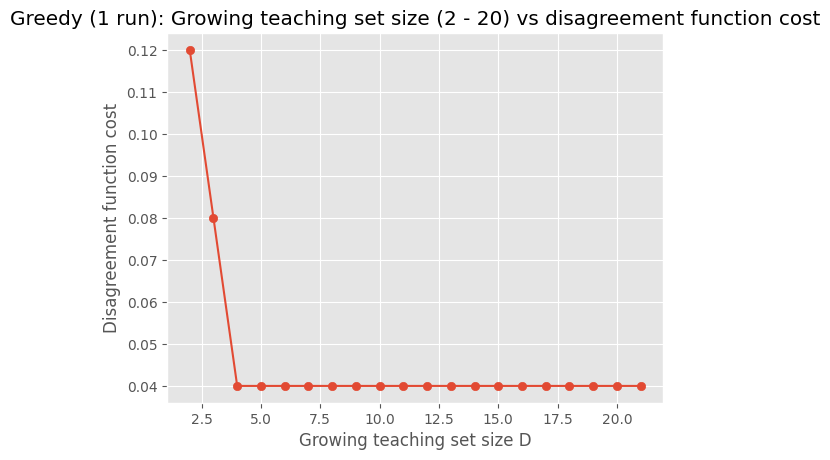

In [21]:
greedy_state_visualizer(20)